<a href="https://colab.research.google.com/github/PrateekCoder/Machine-Learning-End-To-End-Project/blob/main/Machine_Learning_End_To_End_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## YouTube 
###https://youtu.be/fd8lYpnGHy0

In [ ]:
#Import all the required packages
import requests
import gzip
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

## Fetch all the zipped files from IMDB website to our local environment and extract them.

In [ ]:
#URL to fetch all the 6 files.
urls = ['https://datasets.imdbws.com/title.basics.tsv.gz',
        'https://datasets.imdbws.com/title.crew.tsv.gz',
        'https://datasets.imdbws.com/title.akas.tsv.gz',
        'https://datasets.imdbws.com/title.ratings.tsv.gz',
        'https://datasets.imdbws.com/name.basics.tsv.gz',
        'https://datasets.imdbws.com/title.principals.tsv.gz']

#Fetch the data using the above URL and extract all the files.
for url in urls:
    response = requests.get(url)
    filename = url.split("/")[-1]
    
    with open(filename, 'wb') as f:
        f.write(response.content)
        
    with gzip.open(filename, 'rb') as f_in:
        with open(filename[:-3], 'wb') as f_out:
            f_out.write(f_in.read())
            
    print(f"Extracted file: {filename[:-3]}")

'\n#URL to fetch all the 6 files.\nurls = [\'https://datasets.imdbws.com/title.basics.tsv.gz\',\n        \'https://datasets.imdbws.com/title.crew.tsv.gz\',\n        \'https://datasets.imdbws.com/title.akas.tsv.gz\',\n        \'https://datasets.imdbws.com/title.ratings.tsv.gz\',\n        \'https://datasets.imdbws.com/name.basics.tsv.gz\',\n        \'https://datasets.imdbws.com/title.principals.tsv.gz\']\n\n#Fetch the data using the above URL and extract all the files.\nfor url in urls:\n    response = requests.get(url)\n    filename = url.split("/")[-1]\n    \n    with open(filename, \'wb\') as f:\n        f.write(response.content)\n        \n    with gzip.open(filename, \'rb\') as f_in:\n        with open(filename[:-3], \'wb\') as f_out:\n            f_out.write(f_in.read())\n            \n    print(f"Extracted file: {filename[:-3]}")\n  '

## Data Pre-Processing Task

In [ ]:
import pandas as pd

# Read in the entire title.basics.tsv file
title_basics = pd.read_csv("title.basics.tsv", sep='\t',
                           usecols=['tconst', 'titleType', 'primaryTitle', 'startYear', 'runtimeMinutes', 'genres'],
                           dtype={'startYear': float},
                           na_values=['\\N'])

# Read in the rest of the data
title_crew = pd.read_csv("title.crew.tsv", sep='\t',
                         usecols=['tconst', 'directors', 'writers'])
title_ratings = pd.read_csv("title.ratings.tsv", sep='\t',
                            usecols=['tconst', 'averageRating', 'numVotes'])
title_principals = pd.read_csv("title.principals.tsv", sep='\t', 
                               usecols=['tconst', 'nconst', 'category'], 
                               dtype={'nconst': str})

# Read the name.basics.tsv file
names = pd.read_csv("name.basics.tsv", sep='\t', usecols=['nconst', 'primaryName'])

# Merge the title_basics with title_crew, title_ratings and title_principals to get the final dataframe
df = pd.merge(title_basics, title_crew, on='tconst')
df = pd.merge(df, title_ratings, on='tconst')
df = pd.merge(df, title_principals[(title_principals['category'] == 'actor') | (title_principals['category'] == 'actress')], on='tconst')

# Map the nconst to primaryName
directors_map = dict(zip(names['nconst'], names['primaryName']))
writers_map = dict(zip(names['nconst'], names['primaryName']))
actors_map = dict(zip(names['nconst'], names['primaryName']))

# Replace the directors IDs with their names
df['directors'] = df['directors'].str.split(',').apply(lambda x: [directors_map.get(y, y) for y in x])

# Replace the writers IDs with their names
df['writers'] = df['writers'].str.split(',').apply(lambda x: [writers_map.get(y, y) for y in x])

# Replace the actors IDs with their names
actor_names = []
for actors in df['nconst'].str.split(','):
    actor_names_list = []
    for actor in actors:
        actor_names_list.append(actors_map.get(actor, actor))
    actor_names.append(', '.join(actor_names_list))
df['actors'] = actor_names

# Remove the [ and ] characters from the directors, writers, and actors columns
df['directors'] = df['directors'].apply(lambda x: ', '.join([i.strip('[]\'') for i in x]))
df['writers'] = df['writers'].apply(lambda x: ', '.join([i.strip('[]\'') for i in x]))

#While adding actor/actress we added nconst and category column as well, we will drop that
df = df.drop(['nconst', 'category'], axis=1)

# Rename some columns
df = df.rename(columns={'primaryTitle': 'Title', 'startYear': 'Year'})

#Adding ncsont and category column created multiple rows for a single tconst/movie, we would group that into one cell seperated by comma
df = df.groupby(['tconst', 'titleType']).agg({'Title': 'first',
                               'Year': 'first',
                               'runtimeMinutes': 'first',
                               'genres': 'first',
                               'directors': 'first',
                               'writers': 'first',
                               'averageRating': 'first',
                               'numVotes': 'first',
                               'actors': lambda x: ', '.join(set(x))}).reset_index()

# Replace invalid values in Year column with NaN
df['Year'] = df['Year'].replace(-1, np.nan)

# Convert Year column to datetime
df['Year'] = pd.to_datetime(df['Year'], format='%Y', errors='coerce').dt.year.astype('Int64')

df['Movie'] = df.apply(lambda row: row['Title'] + ' (' + str(int(row['Year'])) + ')' if pd.notna(row['Year']) else row['Title'], axis=1)

# Show the final dataframe
df

/usr/local/lib/python3.8/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,tconst,titleType,Title,Year,runtimeMinutes,genres,directors,writers,averageRating,numVotes,actors,Movie
0,tt0000005,short,Blacksmith Scene,1893,1.0,"Comedy,Short",William K.L. Dickson,\N,6.2,2584,"Charles Kayser, John Ott",Blacksmith Scene (1893)
1,tt0000007,short,Corbett and Courtney Before the Kinetograph,1894,1.0,"Short,Sport","William K.L. Dickson, William Heise",\N,5.4,811,"Peter Courtney, James J. Corbett",Corbett and Courtney Before the Kinetograph (1...
2,tt0000008,short,Edison Kinetoscopic Record of a Sneeze,1894,1.0,"Documentary,Short",William K.L. Dickson,\N,5.4,2092,Fred Ott,Edison Kinetoscopic Record of a Sneeze (1894)
3,tt0000009,movie,Miss Jerry,1894,45.0,Romance,Alexander Black,Alexander Black,5.3,204,"Chauncey Depew, William Courtenay, Blanche Bay...",Miss Jerry (1894)
4,tt0000011,short,Akrobatisches Potpourri,1895,1.0,"Documentary,Short",Max Skladanowsky,\N,5.3,363,Grunato,Akrobatisches Potpourri (1895)
...,...,...,...,...,...,...,...,...,...,...,...,...
1004336,tt9916690,tvEpisode,Horrid Henry Delivers the Milk,2012,10,"Adventure,Animation,Comedy",Hilary Audus,"Lucinda Whiteley, Francesca Simon",7.9,8,"Aidan Cook, Sue Elliott-Nichols, Wayne Foreste...",Horrid Henry Delivers the Milk (2012)
1004337,tt9916730,movie,6 Gunn,2017,116,None,Kiran Gawade,Kiran Gawade,8.3,10,"Bhushan Pradhan, Ganesh Vasant Patil, Sunil Ba...",6 Gunn (2017)
1004338,tt9916778,tvEpisode,Escape,2019,None,"Crime,Drama,Mystery",\N,\N,7.2,36,"Ramin Nikoo, Farhad Aeesh, Leila Hatami, Mehra...",Escape (2019)
1004339,tt9916840,tvEpisode,Horrid Henry's Comic Caper,2014,11,"Adventure,Animation,Comedy",Hilary Audus,"Lucinda Whiteley, Francesca Simon",8.8,6,"Aidan Cook, Sue Elliott-Nichols, Wayne Foreste...",Horrid Henry's Comic Caper (2014)


In [ ]:
del title_basics
del title_crew
del title_ratings
del title_principals
del names

## Data Analysis

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


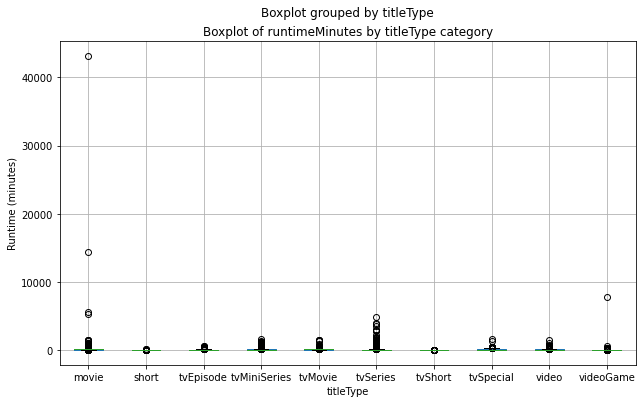

In [ ]:
df['runtimeMinutes'] = df['runtimeMinutes'].fillna(0)
df['titleType'] = df['titleType'].astype(str)
df['runtimeMinutes'] = pd.to_numeric(df['runtimeMinutes'], errors='coerce')

# create a boxplot of runtimeMinutes by titleType category
df.boxplot(column=['runtimeMinutes'], by='titleType', figsize=(10, 6))

# set the title and axes labels
plt.title('Boxplot of runtimeMinutes by titleType category')
plt.xlabel('titleType')
plt.ylabel('Runtime (minutes)')

# show the plot
plt.show()

In [ ]:
highest_runtime_row = df.sort_values(by='runtimeMinutes', ascending=False).iloc[0]

In [ ]:
highest_runtime_row

tconst                                     tt3854496
titleType                                      movie
Title                                       Ambiancé
Year                                            2020
runtimeMinutes                               43200.0
genres                                   Documentary
directors                              Anders Weberg
writers                                Anders Weberg
averageRating                                    4.5
numVotes                                         109
actors            Niklas Hallberg, Stina Pehrsdotter
Movie                                Ambiancé (2020)
Name: 789516, dtype: object

/usr/local/lib/python3.8/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


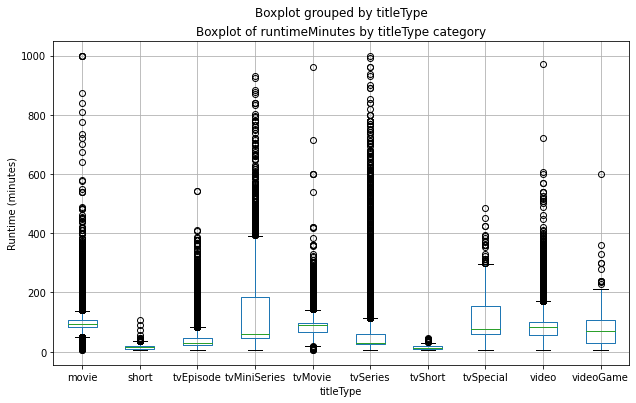

In [ ]:
#We can drop some unusually high runtime values. 
df_check = df[(df['runtimeMinutes'] >= 5) & (df['runtimeMinutes'] <= 1000)]

df_check.boxplot(column=['runtimeMinutes'], by='titleType', figsize=(10, 6))
plt.title('Boxplot of runtimeMinutes by titleType category')
plt.xlabel('titleType')
plt.ylabel('Runtime (minutes)')
plt.show()

#### Lets Keep Only Movie in our DataFrame and Answer Few Questions

In [ ]:
df = df[(df['titleType'] == 'movie')]
df

,tconst,titleType,Title,Year,runtimeMinutes,genres,directors,writers,averageRating,numVotes,actors,Movie
3,tt0000009,movie,Miss Jerry,1894,45.0,Romance,Alexander Black,Alexander Black,5.3,204,"Chauncey Depew, William Courtenay, Blanche Bay...",Miss Jerry (1894)
106,tt0000502,movie,Bohemios,1905,100.0,None,Ricardo de Baños,"Ricardo de Baños, Miguel de Palacios, Guillerm...",4.1,15,"Antonio del Pozo, El Mochuelo",Bohemios (1905)
122,tt0000574,movie,The Story of the Kelly Gang,1906,70.0,"Action,Adventure,Biography",Charles Tait,Charles Tait,6.0,810,"John Tait, Norman Campbell, Elizabeth Tait, Ni...",The Story of the Kelly Gang (1906)
127,tt0000591,movie,The Prodigal Son,1907,90.0,Drama,Michel Carré,Michel Carré,4.4,20,"Gilberte Sergy, Christiane Mandelys, Georges W...",The Prodigal Son (1907)
141,tt0000615,movie,Robbery Under Arms,1907,None,Drama,Charles MacMahon,"Rolf Boldrewood, Charles MacMahon",4.3,24,"George Merriman, William Duff, Lance Vane, Rho...",Robbery Under Arms (1907)
...,...,...,...,...,...,...,...,...,...,...,...,...
1004315,tt9916270,movie,Il talento del calabrone,2020,84,Thriller,Giacomo Cimini,"Giacomo Cimini, Lorenzo Collalti",5.8,1393,"Marina Occhionero, Lorenzo Richelmy, Anna Fogl...",Il talento del calabrone (2020)
1004318,tt9916362,movie,Coven,2020,92,"Drama,History",Pablo Agüero,"Pablo Agüero, Katell Guillou",6.4,5180,"Amaia Aberasturi, Daniel Fanego, Garazi Urkola...",Coven (2020)
1004321,tt9916428,movie,The Secret of China,2019,None,"Adventure,History,War",Jixing Wang,\N,3.8,14,"Kenan Heppe, Vincent Matile, Valery Gadreau, W...",The Secret of China (2019)
1004326,tt9916538,movie,Kuambil Lagi Hatiku,2019,123,Drama,Azhar Kinoi Lubis,"Arief Ash Siddiq, Rino Sarjono, Salman Aristo",8.3,6,"Sahil Shah, Lala Karmela, Ria Irawan, Cut Mini...",Kuambil Lagi Hatiku (2019)


Q1. What are the top 10 highest rated movies by average rating?


In [ ]:
top_10 = df.sort_values(by='averageRating', ascending=False).head(10)
top_10_movies = top_10[['Movie', 'Year', 'averageRating', 'numVotes']]
top_10_movies

,Movie,Year,averageRating,numVotes
516530,Spy Capital (2022),2022,10.0,9
661876,Wrist Lock: The Martial Arts' Influence on Pol...,2022,10.0,11
726267,Heal America (2012),2012,10.0,6
508587,How to Thrive (2022),2022,10.0,13
570768,Ashes to Ashes (2021),2021,10.0,6
661259,"After the Flood: The church, slavery and recon...",2022,10.0,5
903445,Andaz Tera Mera (2022),2022,10.0,6
582956,Transilvania for Sierra Leone (2021),2021,10.0,12
729961,Invisible Hacker (2023),2023,10.0,13
655929,Newlywed Nightmare (2022),2022,10.0,6


Q2. What are the top 10 most popular movies by number of votes?


In [ ]:
# sort the dataframe by numVotes and take the top 10 rows
top_10_most_popular = df.sort_values(by='numVotes', ascending=False).head(10)

# print the top 10 most popular movies by number of votes
print('Top 10 Most Popular Movies by Number of Votes:')
print(top_10_most_popular[['Title', 'numVotes']].to_string(index=False))

Top 10 Most Popular Movies by Number of Votes:
                                            Title  numVotes
                         The Shawshank Redemption   2700614
                                  The Dark Knight   2674425
                                        Inception   2372638
                                       Fight Club   2145602
                                     Forrest Gump   2097762
                                     Pulp Fiction   2073098
                                       The Matrix   1927285
The Lord of the Rings: The Fellowship of the Ring   1889047
                                    The Godfather   1874642
    The Lord of the Rings: The Return of the King   1859673


Q3. What are the top 10 genres in terms of number of movies released?


In [ ]:
# count the number of movies in each genre
genre_counts = df.groupby('genres').size().reset_index(name='count')

# sort by the count in descending order
genre_counts = genre_counts.sort_values(by='count', ascending=False)

# take the top 10 genres by count
top_10_genres = genre_counts.head(10)

# display the top 10 genres by count
print(top_10_genres)

                    genres  count
925                  Drama  48310
615                 Comedy  23661
650           Comedy,Drama   9214
1009         Drama,Romance   8743
842            Documentary   7992
1141                Horror   6485
735         Comedy,Romance   5255
661   Comedy,Drama,Romance   4307
1247              Thriller   4219
0                   Action   3903


Q4. What is the average runtime of movies by year?



In [ ]:
# Compute the average runtime of movies by year
avg_runtime_by_year = df.groupby('Year')['runtimeMinutes'].mean().reset_index()

# Print the result
print(avg_runtime_by_year)

     Year  runtimeMinutes
0    1894       45.000000
1    1903       45.000000
2    1905       48.333333
3    1906       17.500000
4    1907       12.857143
..    ...             ...
116  2019       91.618351
117  2020       93.450429
118  2021       86.780782
119  2022       87.800422
120  2023       86.163004

[121 rows x 2 columns]


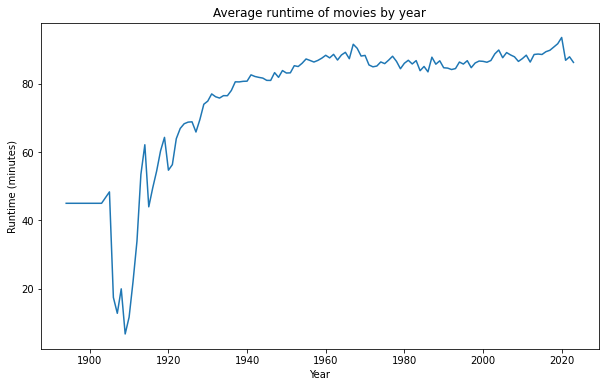

In [ ]:
# Plot the result
avg_runtime_by_year.plot(x='Year', y='runtimeMinutes', kind='line', figsize=(10, 6), legend=None)

# Set the title and axes labels
plt.title('Average runtime of movies by year')
plt.xlabel('Year')
plt.ylabel('Runtime (minutes)')

# Show the plot
plt.show()

Q5. Which directors have made the most movies in the dataset?

In [ ]:
# Count the number of movies for each director
movies_by_director = df['directors'].str.split(', ', expand=True).stack().value_counts()

# Show the top 10 directors with most movies
top_directors = movies_by_director.head(10)
print(top_directors)

\N                           1844
Sam Newfield                  199
Jesús Franco                  187
Michael Curtiz                167
William Beaudine              148
Gilberto Martínez Solares     140
Lesley Selander               133
Lew Landers                   131
Osman F. Seden                129
Godfrey Ho                    128
dtype: int64


Q6. Which writers have written the most movies in the dataset?


In [ ]:
# Count the number of movies for each writer
movies_by_writer = df['writers'].str.split(', ', expand=True).stack().value_counts()

# Show the top 10 writers with most movies
top_writers = movies_by_writer.head(10)
print(top_writers)

\N                     20639
William Shakespeare      387
Safa Önal                294
Erdogan Tünas            259
Bülent Oran              255
Kuang Ni                 212
Jing Wong                198
Jesús Franco             166
Fernando Galiana         165
Chi Udayashankar         155
dtype: int64


Q7. Which actors/actresses have appeared in the most movies in the dataset?


In [ ]:
# Count the number of movies for each actor/actress
movies_by_actor = df['actors'].str.split(', ', expand=True).stack().value_counts()

# Show the top 10 actors/actresses with most movies
top_actors = movies_by_actor.head(10)
print(top_actors)

Brahmanandam          447
Mammootty             344
Mohanlal              335
Mithun Chakraborty    316
Cüneyt Arkin          297
Dharmendra            252
Eric Roberts          232
Sridevi               229
Jagathy Sreekumar     224
Ashok Kumar           222
dtype: int64


Q8. Is there a correlation between runtime and average rating?


In [ ]:
# Compute the correlation between runtime and average rating
corr = df[['runtimeMinutes', 'averageRating']].corr().iloc[0, 1]

# Show the result
print('Correlation between runtime and average rating:', corr)

Correlation between runtime and average rating: 0.014860901305240802


Q9. Is there a correlation between number of votes and average rating?

In [ ]:
# Compute the correlation between number of votes and average rating
corr = df[['numVotes', 'averageRating']].corr().iloc[0, 1]

# Show the result
print('Correlation between number of votes and average rating:', corr)

Correlation between number of votes and average rating: 0.08004122865353928


Q10. Which genres have the highest average rating?


In [ ]:
# Compute the average rating for each genre
avg_rating_by_genre = df.groupby('genres')['averageRating'].mean().sort_values(ascending=False)

# Show the top 10 genres with highest average rating
top_genres_by_rating = avg_rating_by_genre.head(10)
print(top_genres_by_rating)

genres
Biography,Comedy,War           9.9
Documentary,News,Reality-TV    9.9
Documentary,Family,Romance     9.3
Family,Music,Sport             9.1
Comedy,Short                   8.9
Adult,Drama,Sci-Fi             8.9
Reality-TV,Sport               8.7
Comedy,Documentary,Fantasy     8.6
Musical,Sport                  8.5
Documentary,Music,Sci-Fi       8.5
Name: averageRating, dtype: float64


Q11. What is the average rating for movies directed by Christopher Nolan?


In [ ]:
# Compute the average rating for movies directed by Christopher Nolan
nolan_movies = df[df['directors'].str.contains('Christopher Nolan')]
avg_rating_nolan_movies = nolan_movies['averageRating'].mean()

# Show the result
print('Average rating for movies directed by Christopher Nolan:', avg_rating_nolan_movies)

Average rating for movies directed by Christopher Nolan: 8.154545454545454


Q. What is the average rating for movies written by Quentin Tarantino?

In [ ]:
# Compute the average rating for movies written by Quentin Tarantino
tarantino_movies = df[df['writers'].str.contains('Quentin Tarantino')]
avg_rating_tarantino_movies = tarantino_movies['averageRating'].mean()

# Show the result
print('Average rating for movies written by Quentin Tarantino:', avg_rating_tarantino_movies)

Average rating for movies written by Quentin Tarantino: 7.6000000000000005


Q. What are the top 10 movies by Quentin Tarantino and their ratings?

In [ ]:
# Filter the dataframe to include only movies written by Quentin Tarantino
tarantino_movies = df[df['writers'].str.contains('Quentin Tarantino')]

# Sort the movies by average rating in descending order
tarantino_movies = tarantino_movies.sort_values(by='averageRating', ascending=False)

# Select the top 10 movies and their ratings
top_tarantino_movies = tarantino_movies[['Title', 'averageRating']].head(10)

# Print the result
print(top_tarantino_movies)

                                     Title  averageRating
78559                         Pulp Fiction            8.9
883986  Kill Bill: The Whole Bloody Affair            8.8
640177                    Django Unchained            8.4
74159                       Reservoir Dogs            8.3
181782                Inglourious Basterds            8.3
147036                   Kill Bill: Vol. 1            8.2
187563                   Kill Bill: Vol. 2            8.0
76608                         True Romance            7.9
769268                   The Hateful Eight            7.8
925424       Once Upon a Time in Hollywood            7.6


## Building Content-Based Reocmmendation Model


*I will reduce the data to only cotain movies which got realased after 2019. This is required to reduce the RAM consumption and computing resource required. When we calculate the cosine similarity matrix, it would create same number of columns as there are number of rows and this will be a huge dataframe. If you want to see the code for creating df using over 60000 movies you can checkout out this notebook:*
https://github.com/PrateekCoder/Recommendation-Systems/blob/main/Content_Based_Movie_Recommendation_System.ipynb

You can filter out based on other conditions as well like Language or Region as we do have that data but I dropped that column in the Data Pre-Processing task, that should drastically reduce the number of rows.

There are other methods that can be used to take care of this issue like:

1. Reduce the dimensionality of your data: One way to reduce the size of the matrix is to reduce the dimensionality of your data using dimensionality reduction techniques such as Principal Component Analysis (PCA) or Singular Value Decomposition (SVD). These techniques can help you identify the most important features of your data and reduce the size of your matrix by only keeping the most important ones.
2. Use incremental computing: Instead of trying to compute the entire matrix at once, you can use incremental computing to calculate the matrix in parts. This means you would only calculate a small subset of the matrix at a time and save it to disk before moving on to the next part. This way you can avoid running out of memory.
3. Use a distributed computing framework: You can use a distributed computing framework such as Apache Spark or Dask to distribute the computation of the matrix across multiple nodes. This way you can scale your computation to a cluster of machines and make use of their combined memory and processing power.
4. Use a cloud computing service: You can also use a cloud computing service such as Amazon Web Services (AWS) or Google Cloud Platform (GCP) to compute the matrix. These services provide scalable and distributed computing infrastructure that can handle large datasets.

In [ ]:
df = df[df['Year']>=2020]
df

,tconst,titleType,Title,Year,runtimeMinutes,genres,directors,writers,averageRating,numVotes,actors,Movie
38856,tt0062336,movie,The Tango of the Widower and Its Distorting Mi...,2020,70.0,Drama,"Raúl Ruiz, Valeria Sarmiento","Raúl Ruiz, Omar Saavedra Santis",6.4,164,"Shenda Román, Rubén Sotoconil, Claudia Paz, Lu...",The Tango of the Widower and Its Distorting Mi...
68164,tt0097767,movie,Loading Ludwig,2022,65.0,None,Mara Mattuschka,\N,7.0,6,Mara Mattuschka,Loading Ludwig (2022)
85354,tt0119830,movie,One Dog Day,2022,101.0,"Action,Comedy",John Hyams,John Hyams,7.2,28,"Craig Walker, Andrew Sikking, Mella Fazzoli, G...",One Dog Day (2022)
85972,tt0120589,movie,A Dangerous Practice,2022,108.0,Drama,Gustavo Fernández,Jaqueline Vargas,7.1,157,"James Faulkner, Antonio Saboia, Matheus Fagund...",A Dangerous Practice (2022)
109454,tt0173042,movie,Premaloka,2021,154.0,"Drama,Romance",V. Ravichandran,"Panchu Arunachalam, Hamsalekha, V. Ravichandran",7.9,525,"Ambarish, Vishnuvardhan, Juhi Chawla, V. Ravic...",Premaloka (2021)
...,...,...,...,...,...,...,...,...,...,...,...,...
1004122,tt9911196,movie,The Marriage Escape,2020,103,"Comedy,Drama",Johan Nijenhuis,"Radek Bajgar, Herman Finkers, Mirka Zlatníková",7.5,2843,"Ferdi Stofmeel, Leonie ter Braak, Herman Finke...",The Marriage Escape (2020)
1004269,tt9914192,movie,No Gogó do Paulinho,2020,98,Comedy,Roberto Santucci,"Paulo Cursino, Odete Damico, Sergio Martorelli",5.4,279,"Cacau Protásio, Alex Teix, Maurício Manfrini, ...",No Gogó do Paulinho (2020)
1004309,tt9916190,movie,Safeguard,2020,95,"Action,Adventure,Thriller",Fraser Precious,Fraser Precious,3.7,241,"Lee Byford, Takayuki Suzuki, Patrick Gallagher...",Safeguard (2020)
1004315,tt9916270,movie,Il talento del calabrone,2020,84,Thriller,Giacomo Cimini,"Giacomo Cimini, Lorenzo Collalti",5.8,1393,"Marina Occhionero, Lorenzo Richelmy, Anna Fogl...",Il talento del calabrone (2020)


In [ ]:
df.to_csv('test.csv')

In [ ]:
# Combine the relevant columns into a single "content" column
df['content'] = df['Movie'].astype(str) + ' ' + df['runtimeMinutes'].astype(str) + ' ' + df['genres'] + ' ' + df['directors'] + ' ' + df['writers'] + ' ' + df['averageRating'].astype(str) + ' ' + df['numVotes'].astype(str) + df['actors'].astype(str) 

#Data Cleaning to take care of NaN in content column [It replaces NaN with empty strings]
df['content'] = df['Movie'].astype(str) + ' ' + df['runtimeMinutes'].astype(str) + ' ' + df['genres'] + ' ' + df['directors'] + ' ' + df['writers'] + ' ' + df['averageRating'].astype(str) + ' ' + df['numVotes'].astype(str) + df['actors'].astype(str)
df['content'] = df['content'].fillna('')

# Define the TF-IDF vectorizer
tfidf = TfidfVectorizer()

# Fit the vectorizer and transform the "content" column
tfidf_matrix = tfidf.fit_transform(df['content'])

# Compute the cosine similarity matrix
cosine_sim = cosine_similarity(tfidf_matrix, tfidf_matrix)

similarity_df = pd.DataFrame(cosine_sim, index=df['Movie'], columns=df['Movie'])

# Get the indices of the dataframe to use in recommendation function
indices = pd.Series(df.index, index=df['Movie'])

<ipython-input-7-4b01d69c67c6>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['Movie'].astype(str) + ' ' + df['runtimeMinutes'].astype(str) + ' ' + df['genres'] + ' ' + df['directors'] + ' ' + df['writers'] + ' ' + df['averageRating'].astype(str) + ' ' + df['numVotes'].astype(str) + df['actors'].astype(str)
<ipython-input-7-4b01d69c67c6>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['content'] = df['Movie'].astype(str) + ' ' + df['runtimeMinutes'].astype(str) + ' ' + df['genres'] 

In [ ]:
similarity_df

Movie,The Tango of the Widower and Its Distorting Mirror (2020),Loading Ludwig (2022),One Dog Day (2022),A Dangerous Practice (2022),Premaloka (2021),Holy Hollywood (2021),Over-sexed Rugsuckers from Mars (2022),Parinati (2020),Mahua (2021),The Curse (2021),...,The Contrast (2022),Enemy Lines (2020),The Cursed (2021),Le lion (2020),Svartklubb (2020),The Marriage Escape (2020),No Gogó do Paulinho (2020),Safeguard (2020),Il talento del calabrone (2020),Coven (2020)
Movie,,,,,,,,,,,,,,,,,,,,,
The Tango of the Widower and Its Distorting Mirror (2020),1.000000,0.0,0.000000,0.002255,0.001892,0.000000,0.000000,0.004798,0.000000,0.007485,...,0.008972,0.003577,0.009454,0.002980,0.002918,0.010390,0.002807,0.003083,0.002577,0.004763
Loading Ludwig (2022),0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
One Dog Day (2022),0.000000,0.0,1.000000,0.003831,0.000000,0.004483,0.006637,0.000000,0.000000,0.000000,...,0.008335,0.067324,0.000000,0.004519,0.000000,0.003500,0.004257,0.008289,0.000000,0.000000
A Dangerous Practice (2022),0.002255,0.0,0.003831,1.000000,0.002546,0.000000,0.003089,0.002569,0.000000,0.000000,...,0.003880,0.000000,0.000000,0.000000,0.000000,0.002052,0.000000,0.000000,0.000000,0.002550
Premaloka (2021),0.001892,0.0,0.000000,0.002546,1.000000,0.003168,0.000000,0.002156,0.011766,0.002823,...,0.000000,0.000000,0.003566,0.000000,0.000000,0.001722,0.000000,0.000000,0.000000,0.002140
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
The Marriage Escape (2020),0.010390,0.0,0.003500,0.002052,0.001722,0.003318,0.002822,0.004367,0.000000,0.003406,...,0.007627,0.003256,0.004302,0.006057,0.002655,1.000000,0.005705,0.002806,0.002345,0.004335
No Gogó do Paulinho (2020),0.002807,0.0,0.004257,0.000000,0.000000,0.004035,0.003432,0.003198,0.000000,0.000000,...,0.004311,0.003960,0.000000,0.007367,0.003230,0.005705,1.000000,0.003412,0.031248,0.022384
Safeguard (2020),0.003083,0.0,0.008289,0.000000,0.000000,0.000000,0.000000,0.003512,0.000000,0.000000,...,0.026754,0.004348,0.056382,0.020770,0.003546,0.002806,0.003412,1.000000,0.008553,0.003486


In [ ]:
similarity_df.to_pickle('test.pkl')

In [ ]:
# Ask the user for a movie they like
movie = input('Enter a movie you like: ')

Enter a movie you like: Avatar: The Way of Water (2022)


*The recommendation is okay, but could be better if we use movie atleast starting from 2000*

In [ ]:
# Find the index of the movie in the similarity dataframe
movie_index = similarity_df.index.get_loc(movie)

# Get the top 10 most similar movies to the movie
top_10 = similarity_df.iloc[movie_index].sort_values(ascending=False)[1:11]

# Print the top 10 most similar movies to the movie
print(f'Top 10 similar movies to {movie}:')
print(top_10)

Top 10 similar movies to Avatar: The Way of Water (2022):
Movie
Mulan (2020)                   0.173328
Death by 1000 Cuts (2020)      0.158220
Erotomaniac (2022)             0.145605
The Last Son (2021)            0.127615
Hollywood (2020)               0.126942
Black Friday (2020)            0.125252
Mid-Century (2022)             0.121691
Beyond the Shadows (2020)      0.121230
The Bellmen (2020)             0.117995
Her Name Was Christa (2020)    0.117574
Name: Avatar: The Way of Water (2022), dtype: float64


#### We will export this similarity df as pickle and use that in our flask application. Please check the github for flask application files.

## Recommendation System Using IMDB Dataset (2000 to 2022 MOvies) and LSA Dimensionality Reduction.

https://github.com/PrateekCoder/Recommendation-Systems/blob/main/Content_Based_Movie_Recommendation_System_Using_LSA_Dimensionality_Reduction.ipynb